In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 

from tqdm import tqdm
import math

# Creating the Dataset

We will be working with a basic training dataset that has a roughly linear relationship
$$y=\beta^Tx+\epsilon$$
where $\epsilon \sim \mathcal{N}(0,0.1)$ is some gaussian noise.

For ease of plotting, we will consider the case of $x$ representing one-dimensional data, so that each element of $X$ is given by a vector $x = \begin{bmatrix} 1, x_0 \end{bmatrix}$.

In [284]:
pos_samples = 100
neg_samples = 100


pos_mean = 4
pos_sd = 1
pos_examples = -np.random.normal(loc = -pos_mean, scale = pos_sd, size = pos_samples)


neg_mean = 1
neg_sd = 1
neg_examples = -np.random.normal(loc = -neg_mean, scale = neg_sd, size = neg_samples)

X = sm.add_constant(np.concatenate((pos_examples, neg_examples)))
y = np.concatenate((np.ones(pos_samples), np.zeros(neg_samples)))

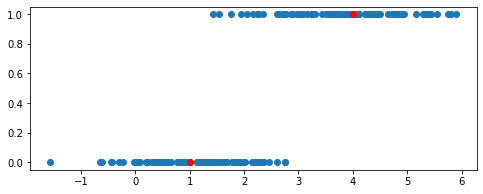

In [285]:
# Here, we plot the data generated above.

plt.figure(figsize=(8,3))
plt.scatter(X[:, 1],y)
plt.scatter([pos_mean], 1, color="red")
plt.scatter([neg_mean], 0, color="red")
plt.show()

# Implementing SGD

We want to find $\text{argmin}_{\beta} L(\beta)$, where the loss function $L(\beta)$ is the Log Loss:
$$L(\beta) = -\frac{1}{n} \sum_{i=1}^n y_i\log(\hat{p}_i)+(1-y_i)\log(1-\hat{p}_i)$$
Where $$\hat{p}_i = \frac{1}{1+e^{-\beta^Tx}}=\sigma(\beta^Tx)$$

To accomplish this with Gradient Descent, we use the update rule
$$\beta \leftarrow \beta - \eta \nabla_{\beta} L$$


However, computing $\nabla_\beta L$ can be very constly when the size of our dataset $X$ is large. To approximate it, we use Stochastic Gradient Descent. First, we choose some random element $x_i$ from our dataset (hence "stochastic") and consider the loss of a single sample $x_i$:

Useful properties of the sigmoid function:
$$\begin{align*}
\sigma(x)+\sigma(-x) &= 1 & \frac{d}{dx} \sigma(x) = \sigma(x)\sigma(-x)\\
\end{align*}$$
With these properties, we derive the derivative of the loss function.
$$\hat{L}(\beta) = -[y_i\log(\sigma(\beta^Tx))+(1-y_i)\log(\sigma(-\beta^Tx))]$$
Taking the derivative, we see that
$$\begin{align*} \nabla_\beta \hat{L} &= -[\frac{d}{d\beta} (y_i\log(\sigma(\beta^Tx))+(1-y_i)\log(\sigma(-\beta^Tx)))]\\
&= -[y_i \frac{1}{\sigma(\beta^Tx)}\sigma(\beta^Tx)\sigma(-\beta^Tx)x +(1-y_i)\frac{1}{\sigma(-\beta^Tx)}\sigma(-\beta^Tx)\sigma(\beta^Tx)x]\\
&= -[y_i \sigma(-\beta^Tx)x+(1-y_i)\sigma(\beta^Tx)(-x)]\\
&= -[(y_i\sigma(-\beta^Tx)-\sigma(\beta^Tx)+y_i\sigma(\beta^Tx))]\\
&= -[(y_i(\sigma(\beta^Tx)+\sigma(-\beta^T)x)-\sigma(\beta^Tx))x]\\
&= -(y_i-\sigma(\beta^Tx))x
\end{align*}$$
Hence, we use the update rule
$$\beta \leftarrow \beta+\eta(y_i-\sigma(\beta^Tx))x$$

In [286]:
def sigmoid(x):
    return 1/(1+math.e**(-x))

In [287]:
def SGD(X, y, time_steps):
    beta = np.zeros(X.shape[1]) # We initialize beta

    for t in tqdm(np.arange(1,time_steps+1)):
        index = np.random.randint(0,X.shape[0]) # Select a random index

        x = X[index]
        y_true = y[index]
        y_hat = sigmoid(np.transpose(beta)@x) # Our prediction is y_i = sigmoid(beta^T x_i)

        eta = 1/math.sqrt(t) # Define the learning rate as 1/sqrt(t)
        g = -(y_true-y_hat)*x # Use our formula for the gradient, as derived earlier


        beta -= eta*g # Update beta according to our update rule
        
    return beta

Running this algorithm on our example dataset with 1e5 timesteps yields good results:

In [288]:
beta_hat = SGD(X,y,1e5)

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 36824.84it/s]


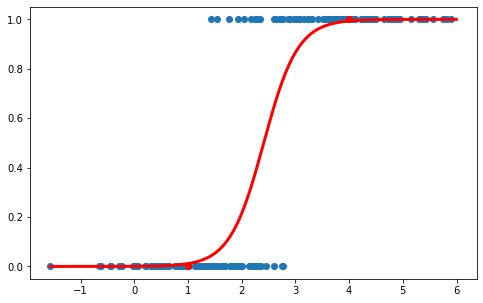

In [290]:
plt.figure(figsize=(8,5))
plt.scatter(X[:, 1],y)

domain = np.arange(np.min(X[:, 1]), np.max(X[:, 1])+0.1, step=0.01)
plt.plot(domain, 1/(1+math.e**(-beta_hat[0]-beta_hat[1]*domain)), color="red", linewidth=3)
plt.scatter([pos_mean], 1, color="red")
plt.scatter([neg_mean], 0, color="red")
plt.show()